<font size="5">Akida 5-Fold-Cross-Validation</font>

In this notebook an Akida model is trained to detect abnormal EEG signals with 5-fold-cross-validation. The cells are not in a close loop, due to memory constrains. Each fold has the same procedure: 1. Train a CNN model, 2. Quantize the CNN model, 3. Convert the quantized CNN model to an Akida SNN.

In [1]:
# Import modules and dependencies

import os
from os import listdir
from os.path import isdir, join
import pathlib

import random
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

import pandas as pd


import akida
from akida import FullyConnected
from akida import evaluate_sparsity
import cnn2snn
from cnn2snn import check_model_compatibility
from cnn2snn import quantize
from cnn2snn import quantize_layer
from cnn2snn import convert

from keras import Model, regularizers
from tensorflow.keras import Input
from tensorflow.keras.layers import (Reshape, Activation, Flatten, Rescaling, Add, Dropout, AveragePooling2D, MaxPooling2D, Softmax)

import akida_models
from akida_models import layer_blocks
from akida_models.layer_blocks import conv_block, separable_conv_block, dense_block

from sklearn.model_selection import KFold
import tensorflow_addons as tfa
from tensorflow.keras.constraints import max_norm


from math import ceil


<font size="5">1. Load Data Set</font>

In [2]:
# If needed, set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
# Define directories

feature_sets_path = '/home/sebastian/Schreibtisch/Masterarbeit/EEG/'
feature_sets_filename = 'final1_eeg_data.npz'

# Define the names of the different models

CNN0_model_filename = 'CNN0_model_raw_eeg.h5'
CNN1_model_filename = 'CNN1_model_raw_eeg.h5'
CNN2_model_filename = 'CNN2_model_raw_eeg.h5'
CNN3_model_filename = 'CNN3_model_raw_eeg.h5'
CNN4_model_filename = 'CNN4_model_raw_eeg.h5'
quantized0_model_filename = 'quantized0_model_raw_eeg.h5'
quantized1_model_filename = 'quantized1_model_raw_eeg.h5'
quantized2_model_filename = 'quantized2_model_raw_eeg.h5'
quantized3_model_filename = 'quantized3_model_raw_eeg.h5'
quantized4_model_filename = 'quantized4_model_raw_eeg.h5'
Akida_model_filename = 'akida_model_raw_eeg.h5'

In [4]:
# Load the data

with np.load(join(feature_sets_path, feature_sets_filename)) as data:
  x_data = data['x']
  y_data = data['y']

In [5]:
# Look at tensor dimensions

print('x_data shape: ', x_data.shape)
print('y_data shape: ', y_data.shape)


x_data shape:  (2993, 22, 15000)
y_data shape:  (2993,)


In [6]:
# Show the dimensions of the label

unique, counts = np.unique(y_data, return_counts=True)
dict(zip(unique, counts))

{0: 1521, 1: 1472}

In [7]:
# Define number of labels

num_labels = len(unique)
print('number of labels: ', num_labels)

number of labels:  2


In [8]:
x_data = np.expand_dims(x_data , axis = -1)

print('Add dimension to data, for grey scale')
print(x_data .shape)

Add dimension to data, for grey scale
(2993, 22, 15000, 1)


In [9]:
# Input shape for CNN is size of MFCC of one sample

input_shape = x_data .shape[1:]
print('EEG Input Shape: ', input_shape)

EEG Input Shape:  (22, 15000, 1)


<font size="5">Fold Number 1</font>

In [9]:
# Define data sets for the first fold

x_train = x_data[598:2993]
y_train = y_data[598:2993]
x_val = x_data[:598]
y_val = y_data[:598]
print(len(x_train))
print(len(x_val))

2395
598


2022-04-16 17:01:21.424374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 17:01:21.639275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 17:01:21.639875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 17:01:21.641598: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22, 15000, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 14976, 40)     1040      
_________________________________________________________________
re_lu (ReLU)                 (None, 22, 14976, 40)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 14976, 40)     17600     
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 14976, 40)     160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 994, 40)       0         
_________________________________________________________________
re_lu_1 (ReLU)               (None, 12, 994, 40)       0 

2022-04-16 17:01:23.366113: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 790350000 exceeds 10% of free system memory.
2022-04-16 17:01:23.795413: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 790350000 exceeds 10% of free system memory.
2022-04-16 17:01:24.095158: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-04-16 17:01:26.754195: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8301
2022-04-16 17:01:29.267587: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-16 17:01:31.319250: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


150/150 [==============================] - ETA: 0s - loss: 14.6869 - accuracy: 0.5244

2022-04-16 17:02:07.634980: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 197340000 exceeds 10% of free system memory.
2022-04-16 17:02:07.737478: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 197340000 exceeds 10% of free system memory.


150/150 [==============================] - 46s 250ms/step - loss: 14.6869 - accuracy: 0.5244 - val_loss: 5.0579 - val_accuracy: 0.5151
Epoch 2/150
150/150 [==============================] - 35s 234ms/step - loss: 9.3968 - accuracy: 0.5315 - val_loss: 3.7323 - val_accuracy: 0.5201
Epoch 3/150
150/150 [==============================] - 35s 234ms/step - loss: 5.5686 - accuracy: 0.5411 - val_loss: 4.1199 - val_accuracy: 0.5602
Epoch 4/150
150/150 [==============================] - 35s 234ms/step - loss: 4.6595 - accuracy: 0.5562 - val_loss: 6.6235 - val_accuracy: 0.5100
Epoch 5/150
150/150 [==============================] - 35s 234ms/step - loss: 4.3354 - accuracy: 0.5511 - val_loss: 3.0689 - val_accuracy: 0.5518
Epoch 6/150
150/150 [==============================] - 35s 234ms/step - loss: 2.3049 - accuracy: 0.5653 - val_loss: 1.9024 - val_accuracy: 0.5819
Epoch 7/150
150/150 [==============================] - 35s 234ms/step - loss: 2.0831 - accuracy: 0.5737 - val_loss: 1.5612 - val_accura

Epoch 57/150
150/150 [==============================] - 35s 233ms/step - loss: 0.5316 - accuracy: 0.7261 - val_loss: 0.5731 - val_accuracy: 0.6856
Epoch 58/150
150/150 [==============================] - 35s 233ms/step - loss: 0.5262 - accuracy: 0.7340 - val_loss: 0.5237 - val_accuracy: 0.7291
Epoch 59/150
150/150 [==============================] - 35s 233ms/step - loss: 0.5345 - accuracy: 0.7207 - val_loss: 0.5294 - val_accuracy: 0.7358
Epoch 60/150
150/150 [==============================] - 35s 233ms/step - loss: 0.5281 - accuracy: 0.7307 - val_loss: 0.5123 - val_accuracy: 0.7207
Epoch 61/150
150/150 [==============================] - 35s 233ms/step - loss: 0.5329 - accuracy: 0.7207 - val_loss: 0.5045 - val_accuracy: 0.7140
Epoch 62/150
150/150 [==============================] - 35s 233ms/step - loss: 0.5341 - accuracy: 0.7190 - val_loss: 0.4960 - val_accuracy: 0.7308
Epoch 63/150
150/150 [==============================] - 35s 233ms/step - loss: 0.5319 - accuracy: 0.7194 - val_loss: 0

2022-04-16 18:29:14.460938: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 790350000 exceeds 10% of free system memory.


Accuracy on train set of CNN: 80.16701340675354 %
Accuracy on validation set of CNN: 76.4214038848877 %


/tmp/ipykernel_69834/143952048.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
/tmp/ipykernel_69834/143952048.py:69: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
/tmp/ipykernel_69834/143952048.py:75: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
/tmp/ipykernel_69834/143952048.py:76: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take p

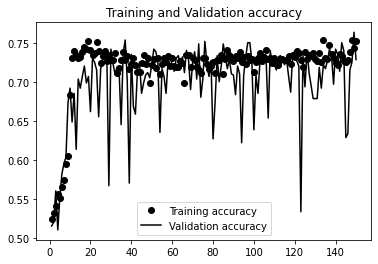

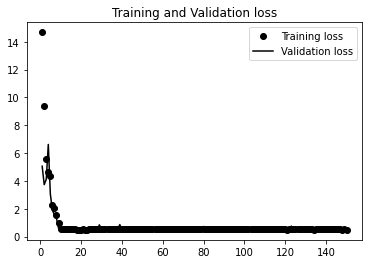

Accuracy on train set of CNN: 80.16701340675354 %
Accuracy on validation set of CNN: 76.4214038848877 %


In [13]:
# Define the CNN model

inputs = Input(shape=input_shape)
x = Rescaling(1. / 255)(inputs)

x = tf.keras.layers.Conv2D(40, (1, 25),kernel_constraint = max_norm(2., axis=(0,1,2)))(inputs)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv2D(40, (11, 1), use_bias=False, kernel_constraint = max_norm(2., axis=(0,1,2)))(x)
x = tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(1, 75), strides=(1, 15))(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2, kernel_constraint = max_norm(0.5))(x)
outputs = tf.keras.layers.Activation('softmax')(x)


CNN_model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_model')
CNN_model.summary()

# Compile the model
CNN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    #optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, nesterov = True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

# Fit data to model


EPOCHS = 150
checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = CNN_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),  
    epochs=EPOCHS,
    batch_size = 16,
    callbacks=[model_checkpoint_callback],
)

CNN_model.load_weights(checkpoint_filepath)

score = CNN_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of CNN:', score[1] * 100,'%')

# Plot results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
plt.plot(epochs, val_loss, 'b', label='Validation loss',color='k')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

score = CNN_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of CNN:', score[1] * 100,'%')
    
models.save_model(CNN_model, CNN0_model_filename)

In [14]:
# Quantize the CNN-model
quantized_model = quantize(CNN_model,
                           input_weight_quantization=8,
                           weight_quantization=4,
                           activ_quantization=4)
quantized_model.summary()

del CNN_model

    # Check model accuracy after quantization

quantized_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22, 15000, 1)]    0         
_________________________________________________________________
conv2d (QuantizedConv2D)     (None, 22, 14976, 40)     1040      
_________________________________________________________________
re_lu (ActivationDiscreteRel (None, 22, 14976, 40)     0         
_________________________________________________________________
conv2d_1 (QuantizedConv2D)   (None, 12, 14976, 40)     17640     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 994, 40)       0         
_________________________________________________________________
re_lu_1 (ActivationDiscreteR (None, 12, 994, 40)       0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 994, 40)       0 

In [15]:
score = quantized_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of quantized CNN:', score[1] * 100,'%')

Accuracy on train set of quantized CNN: 49.14405047893524 %
Accuracy on validation set of quantized CNN: 49.33110475540161 %


In [16]:
EPOCHS = 50
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

history = quantized_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),  
    epochs=EPOCHS,
    batch_size = 16,
    callbacks=[model_checkpoint_callback],
)

Epoch 1/50
150/150 [==============================] - 52s 340ms/step - loss: 0.7500 - accuracy: 0.5324 - val_loss: 0.6671 - val_accuracy: 0.5669
Epoch 2/50
150/150 [==============================] - 51s 339ms/step - loss: 0.6660 - accuracy: 0.5967 - val_loss: 0.6346 - val_accuracy: 0.6722
Epoch 3/50
150/150 [==============================] - 51s 339ms/step - loss: 0.6421 - accuracy: 0.6305 - val_loss: 0.6357 - val_accuracy: 0.6388
Epoch 4/50
150/150 [==============================] - 51s 340ms/step - loss: 0.6351 - accuracy: 0.6443 - val_loss: 0.6170 - val_accuracy: 0.6773
Epoch 5/50
150/150 [==============================] - 51s 340ms/step - loss: 0.5914 - accuracy: 0.6894 - val_loss: 0.6257 - val_accuracy: 0.6371
Epoch 6/50
150/150 [==============================] - 51s 340ms/step - loss: 0.5649 - accuracy: 0.7015 - val_loss: 0.5614 - val_accuracy: 0.7057
Epoch 7/50
150/150 [==============================] - 51s 340ms/step - loss: 0.5497 - accuracy: 0.7081 - val_loss: 0.5592 - val_ac

In [17]:
score = quantized_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of quantized CNN after traning:', score[1] * 100,'%')
score = quantized_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of quantized CNN after training:', score[1] * 100,'%')

Accuracy on train set of quantized CNN after traning: 87.97494769096375 %
Accuracy on validation set of quantized CNN after training: 75.25083422660828 %


In [18]:
models.save_model(quantized_model, quantized0_model_filename)

In [19]:
akida_model = convert(quantized_model)
akida_model.summary()

                  Model Summary                  
_________________________________________________
Input shape     Output shape  Sequences  Layers
[22, 15000, 1]  [1, 1, 2]     1          3     
_________________________________________________

               SW/conv2d-dense (Software)                
_________________________________________________________
Layer (type)         Output shape     Kernel shape     
conv2d (InputConv.)  [14976, 22, 40]  (25, 1, 1, 40)   
_________________________________________________________
conv2d_1 (Conv.)     [994, 12, 40]    (1, 11, 40, 40)  
_________________________________________________________
dense (Fully.)       [1, 1, 2]        (1, 1, 477120, 2)
_________________________________________________________



In [20]:
del quantized_model

In [21]:
results = akida_model.predict(x_train)
accuracy = (y_train == results).mean()

print('SNN accuracy on training set after conversion:', accuracy * 100,'%')

results = akida_model.predict(x_val)
accuracy = (y_val == results).mean()

print('SNN accuracy on validation set after conversion:', accuracy * 100,'%')

SNN accuracy on training set after conversion: 87.97494780793319 %
SNN accuracy on validation set after conversion: 75.08361204013379 %


In [22]:
del akida_model

<font size="5">Fold Number 2</font>

In [23]:
# Define indices of the second fold

train1_index = np.arange(0,598)
train2_index = np.arange(1196,2993)
print(len(train1_index))
print(len(train2_index))
train_index = np.concatenate((train1_index, train2_index))
print(len(train_index))

598
1797
2395


In [24]:
# Define data sets of the second fold

x_train = x_data[train_index]
y_train = y_data[train_index]
x_val = x_data[598:1196]
y_val = y_data[598:1196]

In [25]:
# Due dimensions fit?

print(len(x_train))
print(len(x_val))

2395
598


Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 22, 15000, 1)]    0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 14976, 40)     1040      
_________________________________________________________________
re_lu_4 (ReLU)               (None, 22, 14976, 40)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 14976, 40)     17600     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 14976, 40)     160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 994, 40)       0         
_________________________________________________________________
re_lu_5 (ReLU)               (None, 12, 994, 40)       0 

Epoch 100/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5251 - accuracy: 0.7370 - val_loss: 0.5046 - val_accuracy: 0.7408
Epoch 101/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5233 - accuracy: 0.7370 - val_loss: 0.5261 - val_accuracy: 0.7358
Epoch 102/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5185 - accuracy: 0.7403 - val_loss: 0.5060 - val_accuracy: 0.7391
Epoch 103/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5289 - accuracy: 0.7177 - val_loss: 0.5250 - val_accuracy: 0.7224
Epoch 104/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5331 - accuracy: 0.7240 - val_loss: 0.5247 - val_accuracy: 0.7358
Epoch 105/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5184 - accuracy: 0.7474 - val_loss: 0.6010 - val_accuracy: 0.7207
Epoch 106/150
150/150 [==============================] - 35s 233ms/step - loss: 0.5156 - accuracy: 0.7328 - val_

/tmp/ipykernel_69834/3616554341.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
/tmp/ipykernel_69834/3616554341.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
/tmp/ipykernel_69834/3616554341.py:74: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
/tmp/ipykernel_69834/3616554341.py:75: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will ta

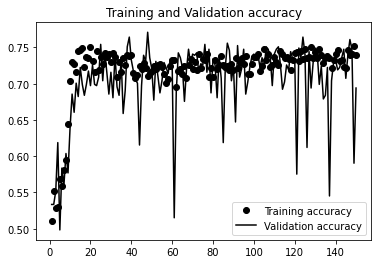

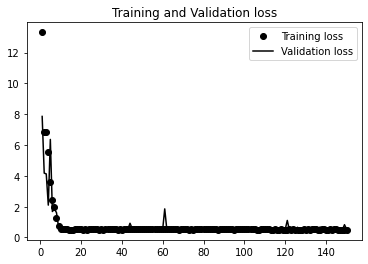

Accuracy on train set of CNN: 77.07724571228027 %
Accuracy on validation set of CNN: 77.09029912948608 %


In [27]:
# Define the CNN model

inputs = Input(shape=input_shape)
x = Rescaling(1. / 255)(inputs)

x = tf.keras.layers.Conv2D(40, (1, 25),kernel_constraint = max_norm(2., axis=(0,1,2)))(inputs)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv2D(40, (11, 1), use_bias=False, kernel_constraint = max_norm(2., axis=(0,1,2)))(x)
x = tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(1, 75), strides=(1, 15))(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2, kernel_constraint = max_norm(0.5))(x)
outputs = tf.keras.layers.Activation('softmax')(x)


CNN_model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_model')
CNN_model.summary()

# Compile the model
CNN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

# Fit data to model


EPOCHS = 150
checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = CNN_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),  
    epochs=EPOCHS,
    batch_size = 16,
    callbacks=[model_checkpoint_callback],
)

CNN_model.load_weights(checkpoint_filepath)

score = CNN_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of CNN:', score[1] * 100,'%')

# Plot results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
plt.plot(epochs, val_loss, 'b', label='Validation loss',color='k')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

score = CNN_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of CNN:', score[1] * 100,'%')
    
models.save_model(CNN_model, CNN1_model_filename)

In [28]:
# Quantize the CNN-model

quantized_model = quantize(CNN_model,
                           input_weight_quantization=8,
                           weight_quantization=4,
                           activ_quantization=4)
quantized_model.summary()


Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 22, 15000, 1)]    0         
_________________________________________________________________
conv2d_4 (QuantizedConv2D)   (None, 22, 14976, 40)     1040      
_________________________________________________________________
re_lu_4 (ActivationDiscreteR (None, 22, 14976, 40)     0         
_________________________________________________________________
conv2d_5 (QuantizedConv2D)   (None, 12, 14976, 40)     17640     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 994, 40)       0         
_________________________________________________________________
re_lu_5 (ActivationDiscreteR (None, 12, 994, 40)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 994, 40)       0 

In [29]:
del CNN_model

In [30]:
# Check model accuracy after quantization

quantized_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

score = quantized_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of quantized CNN:', score[1] * 100,'%')

Accuracy on train set of quantized CNN: 50.688934326171875 %
Accuracy on validation set of quantized CNN: 51.33779048919678 %


In [31]:
EPOCHS = 50
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

history = quantized_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),  
    epochs=EPOCHS,
    batch_size = 16,
    callbacks=[model_checkpoint_callback],
)

Epoch 1/50
150/150 [==============================] - 52s 341ms/step - loss: 0.7444 - accuracy: 0.5470 - val_loss: 0.6584 - val_accuracy: 0.6087
Epoch 2/50
150/150 [==============================] - 51s 339ms/step - loss: 0.6722 - accuracy: 0.5900 - val_loss: 0.6635 - val_accuracy: 0.5669
Epoch 3/50
150/150 [==============================] - 51s 339ms/step - loss: 0.6440 - accuracy: 0.6459 - val_loss: 0.6813 - val_accuracy: 0.6756
Epoch 4/50
150/150 [==============================] - 51s 339ms/step - loss: 0.5722 - accuracy: 0.7215 - val_loss: 0.5774 - val_accuracy: 0.6706
Epoch 5/50
150/150 [==============================] - 51s 339ms/step - loss: 0.5564 - accuracy: 0.7273 - val_loss: 0.5594 - val_accuracy: 0.7090
Epoch 6/50
150/150 [==============================] - 51s 339ms/step - loss: 0.5434 - accuracy: 0.7378 - val_loss: 0.5321 - val_accuracy: 0.7241
Epoch 7/50
150/150 [==============================] - 51s 339ms/step - loss: 0.5163 - accuracy: 0.7486 - val_loss: 0.5311 - val_ac

In [32]:
models.save_model(quantized_model, quantized1_model_filename)

In [33]:
akida_model = convert(quantized_model)
akida_model.summary()

                  Model Summary                  
_________________________________________________
Input shape     Output shape  Sequences  Layers
[22, 15000, 1]  [1, 1, 2]     1          3     
_________________________________________________

              SW/conv2d_4-dense_2 (Software)               
___________________________________________________________
Layer (type)           Output shape     Kernel shape     
conv2d_4 (InputConv.)  [14976, 22, 40]  (25, 1, 1, 40)   
___________________________________________________________
conv2d_5 (Conv.)       [994, 12, 40]    (1, 11, 40, 40)  
___________________________________________________________
dense_2 (Fully.)       [1, 1, 2]        (1, 1, 477120, 2)
___________________________________________________________



In [34]:
del quantized_model

In [35]:
results = akida_model.predict(x_train)
accuracy = (y_train == results).mean()

print('SNN accuracy on training set after conversion:', accuracy * 100,'%')

results = akida_model.predict(x_val)
accuracy = (y_val == results).mean()

print('SNN accuracy on validation set after conversion:', accuracy * 100,'%')

SNN accuracy on training set after conversion: 90.68893528183716 %
SNN accuracy on validation set after conversion: 74.08026755852842 %


In [36]:
del akida_model

<font size="5">Fold Number 3</font>


In [10]:
# Define indices of the third fold

train1_index = np.arange(0,1196)
train2_index = np.arange(1794,2993)
print(len(train1_index))
print(len(train2_index))
train_index = np.concatenate((train1_index, train2_index))
print(len(train_index))

1196
1199
2395


In [11]:
# Define sets of the third fold

x_train = x_data[train_index]
y_train = y_data[train_index]
x_val = x_data[1196:1794]
y_val = y_data[1196:1794]
print(len(x_train))
print(len(x_val))

2395
598


Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 22, 15000, 1)]    0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 14976, 40)     1040      
_________________________________________________________________
re_lu_6 (ReLU)               (None, 22, 14976, 40)     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 14976, 40)     17600     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 14976, 40)     160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 994, 40)       0         
_________________________________________________________________
re_lu_7 (ReLU)               (None, 12, 994, 40)       0 

Epoch 100/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5373 - accuracy: 0.7152 - val_loss: 0.5204 - val_accuracy: 0.7107
Epoch 101/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5151 - accuracy: 0.7344 - val_loss: 0.5363 - val_accuracy: 0.7191
Epoch 102/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5023 - accuracy: 0.7411 - val_loss: 0.5265 - val_accuracy: 0.7358
Epoch 103/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5199 - accuracy: 0.7382 - val_loss: 0.6501 - val_accuracy: 0.5987
Epoch 104/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5186 - accuracy: 0.7403 - val_loss: 0.5607 - val_accuracy: 0.7157
Epoch 105/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5277 - accuracy: 0.7344 - val_loss: 0.5922 - val_accuracy: 0.6605
Epoch 106/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5077 - accuracy: 0.7449 - val_

/tmp/ipykernel_69834/3454101056.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
/tmp/ipykernel_69834/3454101056.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
/tmp/ipykernel_69834/3454101056.py:74: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
/tmp/ipykernel_69834/3454101056.py:75: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will ta

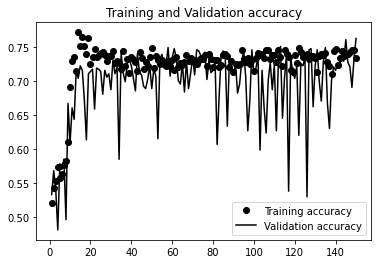

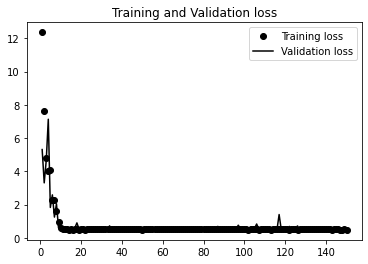

Accuracy on train set of CNN: 77.49478220939636 %
Accuracy on validation set of CNN: 76.25418305397034 %


In [39]:
# Define the CNN model

inputs = Input(shape=input_shape)
x = Rescaling(1. / 255)(inputs)

x = tf.keras.layers.Conv2D(40, (1, 25),kernel_constraint = max_norm(2., axis=(0,1,2)))(inputs)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv2D(40, (11, 1), use_bias=False, kernel_constraint = max_norm(2., axis=(0,1,2)))(x)
x = tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(1, 75), strides=(1, 15))(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2, kernel_constraint = max_norm(0.5))(x)
outputs = tf.keras.layers.Activation('softmax')(x)


CNN_model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_model')
CNN_model.summary()

# Compile the model
CNN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

# Fit data to model


EPOCHS = 150
checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = CNN_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),  
    epochs=EPOCHS,
    batch_size = 16,
    callbacks=[model_checkpoint_callback],
)

CNN_model.load_weights(checkpoint_filepath)

score = CNN_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of CNN:', score[1] * 100,'%')

# Plot results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
plt.plot(epochs, val_loss, 'b', label='Validation loss',color='k')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

score = CNN_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of CNN:', score[1] * 100,'%')
    
models.save_model(CNN_model, CNN2_model_filename)

In [40]:
# Quantize the CNN-model

quantized_model = quantize(CNN_model,
                           input_weight_quantization=8,
                           weight_quantization=4,
                           activ_quantization=4)
quantized_model.summary()

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 22, 15000, 1)]    0         
_________________________________________________________________
conv2d_6 (QuantizedConv2D)   (None, 22, 14976, 40)     1040      
_________________________________________________________________
re_lu_6 (ActivationDiscreteR (None, 22, 14976, 40)     0         
_________________________________________________________________
conv2d_7 (QuantizedConv2D)   (None, 12, 14976, 40)     17640     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 994, 40)       0         
_________________________________________________________________
re_lu_7 (ActivationDiscreteR (None, 12, 994, 40)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 994, 40)       0 

In [41]:
del CNN_model

In [42]:
# Check model accuracy after quantization

quantized_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

score = quantized_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of quantized CNN:', score[1] * 100,'%')

Accuracy on train set of quantized CNN: 49.39457178115845 %
Accuracy on validation set of quantized CNN: 50.167226791381836 %


In [43]:
EPOCHS = 50
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

history = quantized_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),  
    epochs=EPOCHS,
    batch_size = 16,
    callbacks=[model_checkpoint_callback],
)

Epoch 1/50


2022-04-16 23:15:45.987900: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  1/150 [..............................] - ETA: 2:19 - loss: 1.2084 - accuracy: 0.6250

2022-04-16 23:15:46.336342: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  2/150 [..............................] - ETA: 51s - loss: 0.7996 - accuracy: 0.7500 

2022-04-16 23:15:46.682151: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  3/150 [..............................] - ETA: 50s - loss: 0.8450 - accuracy: 0.6667

2022-04-16 23:15:47.028876: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  4/150 [..............................] - ETA: 50s - loss: 0.9288 - accuracy: 0.5938

2022-04-16 23:15:47.375920: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  5/150 [>.............................] - ETA: 50s - loss: 0.9097 - accuracy: 0.5625

2022-04-16 23:15:47.724295: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


150/150 [==============================] - 57s 375ms/step - loss: 0.7401 - accuracy: 0.5403 - val_loss: 0.6777 - val_accuracy: 0.5786
Epoch 2/50
150/150 [==============================] - 58s 389ms/step - loss: 0.6736 - accuracy: 0.5741 - val_loss: 0.6426 - val_accuracy: 0.6739
Epoch 3/50
150/150 [==============================] - 58s 389ms/step - loss: 0.6281 - accuracy: 0.6605 - val_loss: 0.6052 - val_accuracy: 0.6973
Epoch 4/50
150/150 [==============================] - 58s 389ms/step - loss: 0.6000 - accuracy: 0.6727 - val_loss: 0.6150 - val_accuracy: 0.6622
Epoch 5/50
150/150 [==============================] - 58s 389ms/step - loss: 0.5891 - accuracy: 0.6960 - val_loss: 0.5818 - val_accuracy: 0.7174
Epoch 6/50
150/150 [==============================] - 58s 389ms/step - loss: 0.5564 - accuracy: 0.7161 - val_loss: 0.5728 - val_accuracy: 0.7258
Epoch 7/50
150/150 [==============================] - 58s 390ms/step - loss: 0.5287 - accuracy: 0.7307 - val_loss: 0.5690 - val_accuracy: 0.7

In [44]:
models.save_model(quantized_model, quantized2_model_filename)

In [13]:
###### If Pretrained ##########

quantized_model = cnn2snn.load_quantized_model(quantized2_model_filename)

2022-04-17 09:58:25.771011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 09:58:25.975884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 09:58:25.976522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 09:58:25.978124: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [14]:
# Check model accuracy after quantization

quantized_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

score = quantized_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of quantized CNN:', score[1] * 100,'%')

2022-04-17 09:58:42.560471: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 790350000 exceeds 10% of free system memory.
2022-04-17 09:58:42.974963: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 790350000 exceeds 10% of free system memory.
2022-04-17 09:58:43.268521: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-17 09:58:45.897813: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8301
2022-04-17 09:58:48.596209: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-17 09:58:52.135380: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Accuracy on train set of quantized CNN: 94.98956203460693 %
Accuracy on validation set of quantized CNN: 77.25752592086792 %


In [15]:
akida_model = convert(quantized_model)
akida_model.summary()

                  Model Summary                  
_________________________________________________
Input shape     Output shape  Sequences  Layers
[22, 15000, 1]  [1, 1, 2]     1          3     
_________________________________________________

              SW/conv2d_6-dense_3 (Software)               
___________________________________________________________
Layer (type)           Output shape     Kernel shape     
conv2d_6 (InputConv.)  [14976, 22, 40]  (25, 1, 1, 40)   
___________________________________________________________
conv2d_7 (Conv.)       [994, 12, 40]    (1, 11, 40, 40)  
___________________________________________________________
dense_3 (Fully.)       [1, 1, 2]        (1, 1, 477120, 2)
___________________________________________________________



In [16]:
del quantized_model

In [17]:
results = akida_model.predict(x_train)
accuracy = (y_train == results).mean()

print('SNN accuracy on training set after conversion:', accuracy * 100,'%')

results = akida_model.predict(x_val)
accuracy = (y_val == results).mean()

print('SNN accuracy on validation set after conversion:', accuracy * 100,'%')

SNN accuracy on training set after conversion: 95.0313152400835 %
SNN accuracy on validation set after conversion: 77.4247491638796 %


In [18]:
del akida_model

<font size="5">Fold Number 4</font>

In [19]:
# Define the indices of the fourth fold

train1_index = np.arange(0,1794)
train2_index = np.arange(2392,2993)
print(len(train1_index))
print(len(train2_index))
train_index = np.concatenate((train1_index, train2_index))
print(len(train_index))
x_train = x_data[train_index]
y_train = y_data[train_index]
x_val = x_data[1794:2392]
y_val = y_data[1794:2392]
print(len(x_train))
print(len(x_val))

1794
601
2395
2395
598


Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 22, 15000, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 14976, 40)     1040      
_________________________________________________________________
re_lu (ReLU)                 (None, 22, 14976, 40)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 14976, 40)     17600     
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 14976, 40)     160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 994, 40)       0         
_________________________________________________________________
re_lu_1 (ReLU)               (None, 12, 994, 40)       0 

2022-04-17 11:01:29.469587: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 790350000 exceeds 10% of free system memory.
2022-04-17 11:01:29.878087: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 790350000 exceeds 10% of free system memory.


Epoch 1/150
150/150 [==============================] - 41s 249ms/step - loss: 13.2639 - accuracy: 0.5307 - val_loss: 3.1264 - val_accuracy: 0.5635
Epoch 2/150
150/150 [==============================] - 35s 233ms/step - loss: 7.4544 - accuracy: 0.5244 - val_loss: 5.3380 - val_accuracy: 0.5452
Epoch 3/150
150/150 [==============================] - 35s 233ms/step - loss: 6.2295 - accuracy: 0.5545 - val_loss: 3.2726 - val_accuracy: 0.6087
Epoch 4/150
150/150 [==============================] - 35s 233ms/step - loss: 3.7527 - accuracy: 0.5624 - val_loss: 2.5714 - val_accuracy: 0.5970
Epoch 5/150
150/150 [==============================] - 35s 233ms/step - loss: 3.2778 - accuracy: 0.5361 - val_loss: 2.0532 - val_accuracy: 0.5736
Epoch 6/150
150/150 [==============================] - 35s 233ms/step - loss: 2.4265 - accuracy: 0.5737 - val_loss: 2.2166 - val_accuracy: 0.5368
Epoch 7/150
150/150 [==============================] - 35s 233ms/step - loss: 2.0294 - accuracy: 0.5716 - val_loss: 2.1465 

Epoch 57/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5148 - accuracy: 0.7420 - val_loss: 0.5465 - val_accuracy: 0.7391
Epoch 58/150
150/150 [==============================] - 35s 231ms/step - loss: 0.5382 - accuracy: 0.7269 - val_loss: 0.7723 - val_accuracy: 0.6622
Epoch 59/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5246 - accuracy: 0.7282 - val_loss: 0.5951 - val_accuracy: 0.7057
Epoch 60/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5111 - accuracy: 0.7365 - val_loss: 0.5326 - val_accuracy: 0.7425
Epoch 61/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5146 - accuracy: 0.7390 - val_loss: 0.7369 - val_accuracy: 0.6706
Epoch 62/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5394 - accuracy: 0.7161 - val_loss: 0.5331 - val_accuracy: 0.7040
Epoch 63/150
150/150 [==============================] - 35s 232ms/step - loss: 0.5237 - accuracy: 0.7395 - val_loss: 0

2022-04-17 12:28:27.075228: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 790350000 exceeds 10% of free system memory.


Accuracy on train set of CNN: 78.0793309211731 %
Accuracy on validation set of CNN: 74.2474913597107 %


/tmp/ipykernel_83777/3134749192.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
/tmp/ipykernel_83777/3134749192.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
/tmp/ipykernel_83777/3134749192.py:74: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
/tmp/ipykernel_83777/3134749192.py:75: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will ta

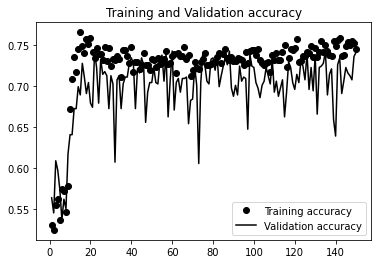

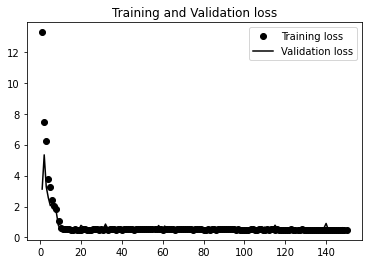

Accuracy on train set of CNN: 78.0793309211731 %
Accuracy on validation set of CNN: 74.2474913597107 %


In [20]:
# Define the CNN model

inputs = Input(shape=input_shape)
x = Rescaling(1. / 255)(inputs)

x = tf.keras.layers.Conv2D(40, (1, 25),kernel_constraint = max_norm(2., axis=(0,1,2)))(inputs)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv2D(40, (11, 1), use_bias=False, kernel_constraint = max_norm(2., axis=(0,1,2)))(x)
x = tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(1, 75), strides=(1, 15))(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2, kernel_constraint = max_norm(0.5))(x)
outputs = tf.keras.layers.Activation('softmax')(x)


CNN_model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_model')
CNN_model.summary()

# Compile the model
CNN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

# Fit data to model


EPOCHS = 150
checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = CNN_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),  
    epochs=EPOCHS,
    batch_size = 16,
    callbacks=[model_checkpoint_callback],
)

CNN_model.load_weights(checkpoint_filepath)

score = CNN_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of CNN:', score[1] * 100,'%')

# Plot results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
plt.plot(epochs, val_loss, 'b', label='Validation loss',color='k')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

score = CNN_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of CNN:', score[1] * 100,'%')
    
models.save_model(CNN_model, CNN3_model_filename)

In [25]:
##### If pretrained #### 

CNN_model = models.load_model(CNN3_model_filename)

In [26]:
# Quantize the CNN-model
quantized_model = quantize(CNN_model,
                           input_weight_quantization=8,
                           weight_quantization=4,
                           activ_quantization=4)
quantized_model.summary()

del CNN_model

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 22, 15000, 1)]    0         
_________________________________________________________________
conv2d (QuantizedConv2D)     (None, 22, 14976, 40)     1040      
_________________________________________________________________
re_lu (ActivationDiscreteRel (None, 22, 14976, 40)     0         
_________________________________________________________________
conv2d_1 (QuantizedConv2D)   (None, 12, 14976, 40)     17640     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 994, 40)       0         
_________________________________________________________________
re_lu_1 (ActivationDiscreteR (None, 12, 994, 40)       0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 994, 40)       0 

In [27]:
# Check model accuracy after quantization

quantized_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

score = quantized_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of quantized CNN:', score[1] * 100,'%')



Accuracy on train set of quantized CNN: 50.52192211151123 %
Accuracy on validation set of quantized CNN: 53.678929805755615 %


In [28]:
EPOCHS = 50
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

history = quantized_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),  
    epochs=EPOCHS,
    batch_size = 16,
    callbacks=[model_checkpoint_callback],
)

models.save_model(quantized_model, quantized3_model_filename)

Epoch 1/50
150/150 [==============================] - 52s 341ms/step - loss: 0.6884 - accuracy: 0.5344 - val_loss: 0.6885 - val_accuracy: 0.5418
Epoch 2/50


2022-04-17 13:06:40.300985: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  1/150 [..............................] - ETA: 52s - loss: 0.6878 - accuracy: 0.5000

2022-04-17 13:06:40.649613: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  2/150 [..............................] - ETA: 51s - loss: 0.6793 - accuracy: 0.5625

2022-04-17 13:06:40.998478: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  3/150 [..............................] - ETA: 51s - loss: 0.6750 - accuracy: 0.6042

2022-04-17 13:06:41.345857: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  4/150 [..............................] - ETA: 50s - loss: 0.6782 - accuracy: 0.5625

2022-04-17 13:06:41.693302: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  5/150 [>.............................] - ETA: 50s - loss: 0.6760 - accuracy: 0.5875

2022-04-17 13:06:42.041038: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  6/150 [>.............................] - ETA: 50s - loss: 0.6734 - accuracy: 0.5938

2022-04-17 13:06:42.388497: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  7/150 [>.............................] - ETA: 49s - loss: 0.6749 - accuracy: 0.5893

2022-04-17 13:06:42.735236: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  8/150 [>.............................] - ETA: 49s - loss: 0.6744 - accuracy: 0.5781

2022-04-17 13:06:43.081468: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  9/150 [>.............................] - ETA: 48s - loss: 0.6802 - accuracy: 0.5486

2022-04-17 13:06:43.429241: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


150/150 [==============================] - 56s 373ms/step - loss: 0.6731 - accuracy: 0.5871 - val_loss: 0.6672 - val_accuracy: 0.6154
Epoch 3/50
150/150 [==============================] - 56s 373ms/step - loss: 0.6591 - accuracy: 0.6217 - val_loss: 0.6794 - val_accuracy: 0.5569
Epoch 4/50
150/150 [==============================] - 56s 372ms/step - loss: 0.6550 - accuracy: 0.6418 - val_loss: 0.6896 - val_accuracy: 0.5100
Epoch 5/50
150/150 [==============================] - 56s 372ms/step - loss: 0.6540 - accuracy: 0.6200 - val_loss: 0.6234 - val_accuracy: 0.6706
Epoch 6/50
150/150 [==============================] - 56s 372ms/step - loss: 0.6292 - accuracy: 0.6543 - val_loss: 0.6191 - val_accuracy: 0.6739
Epoch 7/50
150/150 [==============================] - 56s 370ms/step - loss: 0.6053 - accuracy: 0.6906 - val_loss: 0.6065 - val_accuracy: 0.6656
Epoch 8/50
150/150 [==============================] - 56s 370ms/step - loss: 0.5828 - accuracy: 0.7136 - val_loss: 0.6140 - val_accuracy: 0.6

In [29]:
score = quantized_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of quantized CNN:', score[1] * 100,'%')

Accuracy on train set of quantized CNN: 89.31106328964233 %
Accuracy on validation set of quantized CNN: 73.9130437374115 %


In [30]:
akida_model = convert(quantized_model)
akida_model.summary()
del quantized_model

                  Model Summary                  
_________________________________________________
Input shape     Output shape  Sequences  Layers
[22, 15000, 1]  [1, 1, 2]     1          3     
_________________________________________________

               SW/conv2d-dense (Software)                
_________________________________________________________
Layer (type)         Output shape     Kernel shape     
conv2d (InputConv.)  [14976, 22, 40]  (25, 1, 1, 40)   
_________________________________________________________
conv2d_1 (Conv.)     [994, 12, 40]    (1, 11, 40, 40)  
_________________________________________________________
dense (Fully.)       [1, 1, 2]        (1, 1, 477120, 2)
_________________________________________________________



In [31]:
results = akida_model.predict(x_train)
accuracy = (y_train == results).mean()

print('SNN accuracy on training set after conversion:', accuracy * 100,'%')

results = akida_model.predict(x_val)
accuracy = (y_val == results).mean()

print('SNN accuracy on validation set after conversion:', accuracy * 100,'%')

del akida_model

SNN accuracy on training set after conversion: 89.39457202505218 %
SNN accuracy on validation set after conversion: 73.7458193979933 %


<font size="5">Fold Number 5</font>

In [37]:
# Define the sets of the fifth fold

x_train = x_data[:2393]
y_train = y_data[:2393]
x_val = x_data[2395:2993]
y_val = y_data[2395:2993]
print(len(x_train))
print(len(x_val))

2393
598


Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 22, 15000, 1)]    0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 14976, 40)     1040      
_________________________________________________________________
re_lu_4 (ReLU)               (None, 22, 14976, 40)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 14976, 40)     17600     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 14976, 40)     160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 994, 40)       0         
_________________________________________________________________
re_lu_5 (ReLU)               (None, 12, 994, 40)       0 

Epoch 100/150
150/150 [==============================] - 35s 234ms/step - loss: 0.5224 - accuracy: 0.7234 - val_loss: 0.6177 - val_accuracy: 0.6388
Epoch 101/150
150/150 [==============================] - 35s 234ms/step - loss: 0.5252 - accuracy: 0.7321 - val_loss: 0.5313 - val_accuracy: 0.7191
Epoch 102/150
150/150 [==============================] - 35s 234ms/step - loss: 0.5214 - accuracy: 0.7321 - val_loss: 0.5338 - val_accuracy: 0.7107
Epoch 103/150
150/150 [==============================] - 35s 234ms/step - loss: 0.5338 - accuracy: 0.7313 - val_loss: 0.5263 - val_accuracy: 0.7224
Epoch 104/150
150/150 [==============================] - 35s 234ms/step - loss: 0.5082 - accuracy: 0.7359 - val_loss: 0.5326 - val_accuracy: 0.7341
Epoch 105/150
150/150 [==============================] - 35s 234ms/step - loss: 0.5184 - accuracy: 0.7359 - val_loss: 0.5202 - val_accuracy: 0.7408
Epoch 106/150
150/150 [==============================] - 35s 234ms/step - loss: 0.5352 - accuracy: 0.7171 - val_

/tmp/ipykernel_83777/4137306378.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
/tmp/ipykernel_83777/4137306378.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
/tmp/ipykernel_83777/4137306378.py:74: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
/tmp/ipykernel_83777/4137306378.py:75: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will ta

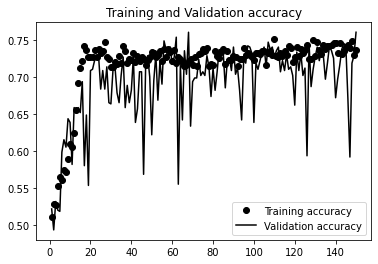

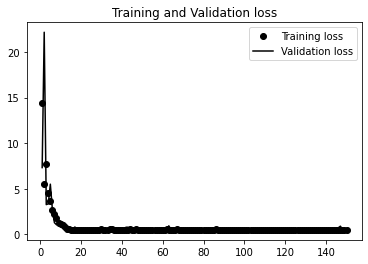

Accuracy on train set of CNN: 79.27287817001343 %
Accuracy on validation set of CNN: 76.0869562625885 %


In [38]:
# Define the CNN model

inputs = Input(shape=input_shape)
x = Rescaling(1. / 255)(inputs)

x = tf.keras.layers.Conv2D(40, (1, 25),kernel_constraint = max_norm(2., axis=(0,1,2)))(inputs)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv2D(40, (11, 1), use_bias=False, kernel_constraint = max_norm(2., axis=(0,1,2)))(x)
x = tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(1, 75), strides=(1, 15))(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2, kernel_constraint = max_norm(0.5))(x)
outputs = tf.keras.layers.Activation('softmax')(x)


CNN_model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_model')
CNN_model.summary()

# Compile the model
CNN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

# Fit data to model


EPOCHS = 150
checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = CNN_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),  
    epochs=EPOCHS,
    batch_size = 16,
    callbacks=[model_checkpoint_callback],
)

CNN_model.load_weights(checkpoint_filepath)

score = CNN_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of CNN:', score[1] * 100,'%')

# Plot results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy',color='k')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='k')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss',color='k')
plt.plot(epochs, val_loss, 'b', label='Validation loss',color='k')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

score = CNN_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of CNN:', score[1] * 100,'%')
    
models.save_model(CNN_model, CNN4_model_filename)

In [39]:
# Quantize the CNN-model

quantized_model = quantize(CNN_model,
                           input_weight_quantization=8,
                           weight_quantization=4,
                           activ_quantization=4)
quantized_model.summary()

del CNN_model

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 22, 15000, 1)]    0         
_________________________________________________________________
conv2d_4 (QuantizedConv2D)   (None, 22, 14976, 40)     1040      
_________________________________________________________________
re_lu_4 (ActivationDiscreteR (None, 22, 14976, 40)     0         
_________________________________________________________________
conv2d_5 (QuantizedConv2D)   (None, 12, 14976, 40)     17640     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 994, 40)       0         
_________________________________________________________________
re_lu_5 (ActivationDiscreteR (None, 12, 994, 40)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 994, 40)       0 

In [40]:
# Check model accuracy after quantization

quantized_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

score = quantized_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of quantized CNN:', score[1] * 100,'%')


Accuracy on train set of quantized CNN: 49.22691285610199 %
Accuracy on validation set of quantized CNN: 49.163880944252014 %


In [41]:
EPOCHS = 50
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

history = quantized_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),  
    epochs=EPOCHS,
    batch_size = 16,
    callbacks=[model_checkpoint_callback],
)

score = quantized_model.evaluate(x_train, y_train, verbose=0)
print('Accuracy on train set of quantized CNN:', score[1] * 100,'%')
score = quantized_model.evaluate(x_val, y_val, verbose=0)
print('Accuracy on validation set of quantized CNN:', score[1] * 100,'%')

models.save_model(quantized_model, quantized4_model_filename)

Epoch 1/50
150/150 [==============================] - 56s 370ms/step - loss: 0.7155 - accuracy: 0.5295 - val_loss: 0.6943 - val_accuracy: 0.5201
Epoch 2/50
150/150 [==============================] - 55s 369ms/step - loss: 0.6821 - accuracy: 0.5654 - val_loss: 0.6645 - val_accuracy: 0.6154
Epoch 3/50
150/150 [==============================] - 55s 369ms/step - loss: 0.6599 - accuracy: 0.6034 - val_loss: 0.6657 - val_accuracy: 0.5619
Epoch 4/50
150/150 [==============================] - 55s 369ms/step - loss: 0.6359 - accuracy: 0.6410 - val_loss: 0.6151 - val_accuracy: 0.6572
Epoch 5/50
150/150 [==============================] - 55s 369ms/step - loss: 0.5843 - accuracy: 0.6949 - val_loss: 0.5785 - val_accuracy: 0.7224
Epoch 6/50
150/150 [==============================] - 55s 369ms/step - loss: 0.5695 - accuracy: 0.7004 - val_loss: 0.5732 - val_accuracy: 0.7191
Epoch 7/50
150/150 [==============================] - 55s 369ms/step - loss: 0.5578 - accuracy: 0.7163 - val_loss: 0.5711 - val_ac

In [42]:
akida_model = convert(quantized_model)
akida_model.summary()
del quantized_model

                  Model Summary                  
_________________________________________________
Input shape     Output shape  Sequences  Layers
[22, 15000, 1]  [1, 1, 2]     1          3     
_________________________________________________

              SW/conv2d_4-dense_2 (Software)               
___________________________________________________________
Layer (type)           Output shape     Kernel shape     
conv2d_4 (InputConv.)  [14976, 22, 40]  (25, 1, 1, 40)   
___________________________________________________________
conv2d_5 (Conv.)       [994, 12, 40]    (1, 11, 40, 40)  
___________________________________________________________
dense_2 (Fully.)       [1, 1, 2]        (1, 1, 477120, 2)
___________________________________________________________



In [43]:
results = akida_model.predict(x_train)
accuracy = (y_train == results).mean()

print('SNN accuracy on training set after conversion:', accuracy * 100,'%')

results = akida_model.predict(x_val)
accuracy = (y_val == results).mean()

print('SNN accuracy on validation set after conversion:', accuracy * 100,'%')

del akida_model

SNN accuracy on training set after conversion: 95.23610530714585 %
SNN accuracy on validation set after conversion: 75.4180602006689 %
